# 📘 Real-Time Crypto Price Predictor

### 🎯 Objective
To predict the price & its movement (Up/Down) of cryptocurrencies like Bitcoin (BTC) and Ethereum (ETH) using LightGBM classifier and financial indicators.

### ❓ Problem Statement
Cryptocurrency markets are volatile and require robust predictive tools. This project develops a machine learning-based binary classifier to anticipate the short-term direction of prices.

### 🧾 Data Source
- CryptoCompare API (or CSV dump from their data)
- Features: open, high, low, volumeFrom, volumeTo, day, month, year, dayofweek
- Engineered: RSI, SMA, EMA, % Change, Volatility

### 🧠 Approach
1. **Data Collection & Preprocessing**
2. **Feature Engineering**
3. **Exploratory Data Analysis (EDA)**
4. **Model Training using LightGBM**
5. **Evaluation (AUC, ROC, Classification Report)**
6. **Multi-Crypto Symbol Support**
7. **Visualization of Predictions & Indicators**

### 📊 Key Evaluation Metrics
- ROC-AUC Score
- Precision, Recall, F1-score
- Confusion Matrix
- Accuracy


In [ ]:
pip install ydata_profiling

In [ ]:
import requests
import pandas as pd
import numpy as np
import logging
import os
import joblib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport


In [ ]:
# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("crypto_model.log"),
        logging.StreamHandler()
    ]
)

MODEL_PATH = "crypto_model.pkl"

In [ ]:
# 1. Fetch CryptoCompare Data
def fetch_crypto_data(symbol="BTC", currency="USD", limit=180):
    try:
        logging.info(f"Fetching real-time data for {symbol}...")
        url = "https://min-api.cryptocompare.com/data/v2/histoday"
        params = {"fsym": symbol, "tsym": currency, "limit": limit}
        response = requests.get(url, params=params)
        data = response.json()

        if "Data" not in data or "Data" not in data["Data"]:
            raise ValueError("API response is malformed.")

        df = pd.DataFrame(data["Data"]["Data"])
        df["time"] = pd.to_datetime(df["time"], unit="s")
        logging.info(f"Data fetched successfully for {symbol}!")
        return df
    except Exception as e:
        logging.error(f"Error fetching crypto data for {symbol}: {e}")
        raise


In [ ]:
# 2. Feature Engineering
def create_features(df):
    try:
        logging.info("⚙️ Creating features...")
        df["day"] = df["time"].dt.day
        df["month"] = df["time"].dt.month
        df["year"] = df["time"].dt.year
        df["dayofweek"] = df["time"].dt.dayofweek
        df["target"] = df["close"].shift(-1)
        df.dropna(inplace=True)
        logging.info("Features created.")
        return df
    except Exception as e:
        logging.error(f"Error in feature engineering: {e}")
        raise

In [ ]:
def explore_crypto_data(df):
  # Generate the EDA report
  global profile
  profile = ProfileReport(df, title="Real Time Crypto Prediction EDA Report")
  return profile

In [ ]:
# Calling EDA report for statstical analysis

# Fetch data
df = fetch_crypto_data()

# Feature Engineering
df = create_features(df)

# Exploring features
explore_crypto_data(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 88.35it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# 7. Plot Correlation Matrix
def plot_correlation_matrix(df):
    features = ["open", "high", "low", "volumefrom", "volumeto", "day", "month", "year", "dayofweek"]
    correlation = df[features].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix of Features")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_univariate_distributions(df, features):

    #Plots histograms and KDE plots for each feature in the dataset.

    num_features = len(features)
    ncols = 3
    nrows = (num_features + ncols - 1) // ncols

    plt.figure(figsize=(18, 5 * nrows))
    for i, feature in enumerate(features):
        plt.subplot(nrows, ncols, i + 1)
        sns.histplot(df[feature], kde=True, bins=30, color="blue")
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.suptitle("Univariate Feature Distributions", fontsize=16, y=1.02)
    plt.show()


In [ ]:
def plot_bivariate_relationships(df, features, target="target"):

    #Plots bivariate scatter plots of each feature vs the target variable with regression line.

    assert isinstance(target, str), "'target' must be a column name (string)."

    num_features = len(features)
    ncols = 3
    nrows = (num_features + ncols - 1) // ncols

    plt.figure(figsize=(18, 5 * nrows))
    for i, feature in enumerate(features):
        plt.subplot(nrows, ncols, i + 1)
        sns.regplot(data=df, x=feature, y=target, scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
        plt.title(f"{feature} vs {target}")
        plt.xlabel(feature)
        plt.ylabel(target)
    plt.tight_layout()
    plt.suptitle("Bivariate Feature-Target Relationships", fontsize=16, y=1.02)
    plt.show()

In [ ]:
# 3. Train or Retrain Models (LightGBM, XGBoost, RandomForest)
def train_models(df, retrain=False):
    features = ["open", "high", "low", "volumefrom", "volumeto", "day", "month", "year", "dayofweek"]
    X = df[features]
    y = df["target"]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {}

    if not retrain and os.path.exists(MODEL_PATH):
        logging.info("Loading existing models...")
        models = joblib.load(MODEL_PATH)
    else:
        logging.info("Training models...")

        # LightGBM
        lgbm = LGBMRegressor(
            objective='regression',
            learning_rate=0.02,
            num_leaves=31,
            max_depth=6,
            min_data_in_leaf=30,
            lambda_l1=0.1,
            lambda_l2=0.1,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            bagging_freq=5,
            n_estimators=1000
        )
        lgbm.fit(X_train, y_train)
        models['LightGBM'] = lgbm

        # XGBoost
        xgb = XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.02,
            max_depth=6,
            n_estimators=1000
        )
        xgb.fit(X_train, y_train)
        models['XGBoost'] = xgb

        # RandomForest
        rf = RandomForestRegressor(
            n_estimators=1000,
            max_depth=6,
            random_state=42
        )
        rf.fit(X_train, y_train)
        models['RandomForest'] = rf

        # Save models
        joblib.dump(models, MODEL_PATH)
        logging.info("Models trained and saved!")

    return models, X_val, y_val

In [ ]:
# 4. Evaluate Models
def evaluate_model(models, X_val, y_val):
    evaluation_results = {}

    try:
        for model_name, model in models.items():
            y_pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            r2 = r2_score(y_val, y_pred)

            evaluation_results[model_name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

            logging.info(f"   Evaluation Results for {model_name}:")
            logging.info(f"   MAE:  {mae:.2f}")
            logging.info(f"   RMSE: {rmse:.2f}")
            logging.info(f"   R²:   {r2:.4f}")

        return evaluation_results
    except Exception as e:
        logging.error(f"Evaluation failed: {e}")
        raise

In [ ]:
# 5. Plot Actual vs Predicted for Each Model Individually
def plot_comparison_individual(y_val, models, X_val):
    # Plot LightGBM Comparison
    lgbm_pred = models['LightGBM'].predict(X_val)
    plt.figure(figsize=(8, 5))
    plt.plot(y_val.values, label='Actual', marker='o', linestyle='--')
    plt.plot(lgbm_pred, label='LightGBM Predicted', marker='x')
    plt.title("LightGBM - Actual vs Predicted Close Price (Validation Set)")
    plt.xlabel("Validation Samples")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot XGBoost Comparison
    xgb_pred = models['XGBoost'].predict(X_val)
    plt.figure(figsize=(8, 5))
    plt.plot(y_val.values, label='Actual', marker='o', linestyle='--')
    plt.plot(xgb_pred, label='XGBoost Predicted', marker='x')
    plt.title("XGBoost - Actual vs Predicted Close Price (Validation Set)")
    plt.xlabel("Validation Samples")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot RandomForest Comparison
    rf_pred = models['RandomForest'].predict(X_val)
    plt.figure(figsize=(8, 5))
    plt.plot(y_val.values, label='Actual', marker='o', linestyle='--')
    plt.plot(rf_pred, label='RandomForest Predicted', marker='x')
    plt.title("RandomForest - Actual vs Predicted Close Price (Validation Set)")
    plt.xlabel("Validation Samples")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# 6. Plot Next Hour Prediction (Line Chart for Each Model)
def plot_next_hour_prediction(models, df):
    last_row = df.iloc[-1]
    last_features = last_row[["open", "high", "low", "volumefrom", "volumeto", "day", "month", "year", "dayofweek"]].values.reshape(1, -1)

    # Predict the next hour for each model
    next_hour_predictions = {}
    for model_name, model in models.items():
        next_hour_predictions[model_name] = model.predict(last_features)[0]

    # Plot for LightGBM
    plt.figure(figsize=(10, 6))
    plt.plot(df["time"].tail(10), df["close"].tail(10), label="Actual Close", marker='o')
    plt.scatter(df["time"].iloc[-1] + pd.Timedelta(hours=1), next_hour_predictions['LightGBM'], color='blue', label=f'LightGBM Next Hour Prediction', marker='x', s=100)
    plt.title("LightGBM - Next Hour Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot for XGBoost
    plt.figure(figsize=(10, 6))
    plt.plot(df["time"].tail(10), df["close"].tail(10), label="Actual Close", marker='o')
    plt.scatter(df["time"].iloc[-1] + pd.Timedelta(hours=1), next_hour_predictions['XGBoost'], color='orange', label=f'XGBoost Next Hour Prediction', marker='x', s=100)
    plt.title("XGBoost - Next Hour Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot for RandomForest
    plt.figure(figsize=(10, 6))
    plt.plot(df["time"].tail(10), df["close"].tail(10), label="Actual Close", marker='o')
    plt.scatter(df["time"].iloc[-1] + pd.Timedelta(hours=1), next_hour_predictions['RandomForest'], color='green', label=f'RandomForest Next Hour Prediction', marker='x', s=100)
    plt.title("RandomForest - Next Hour Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

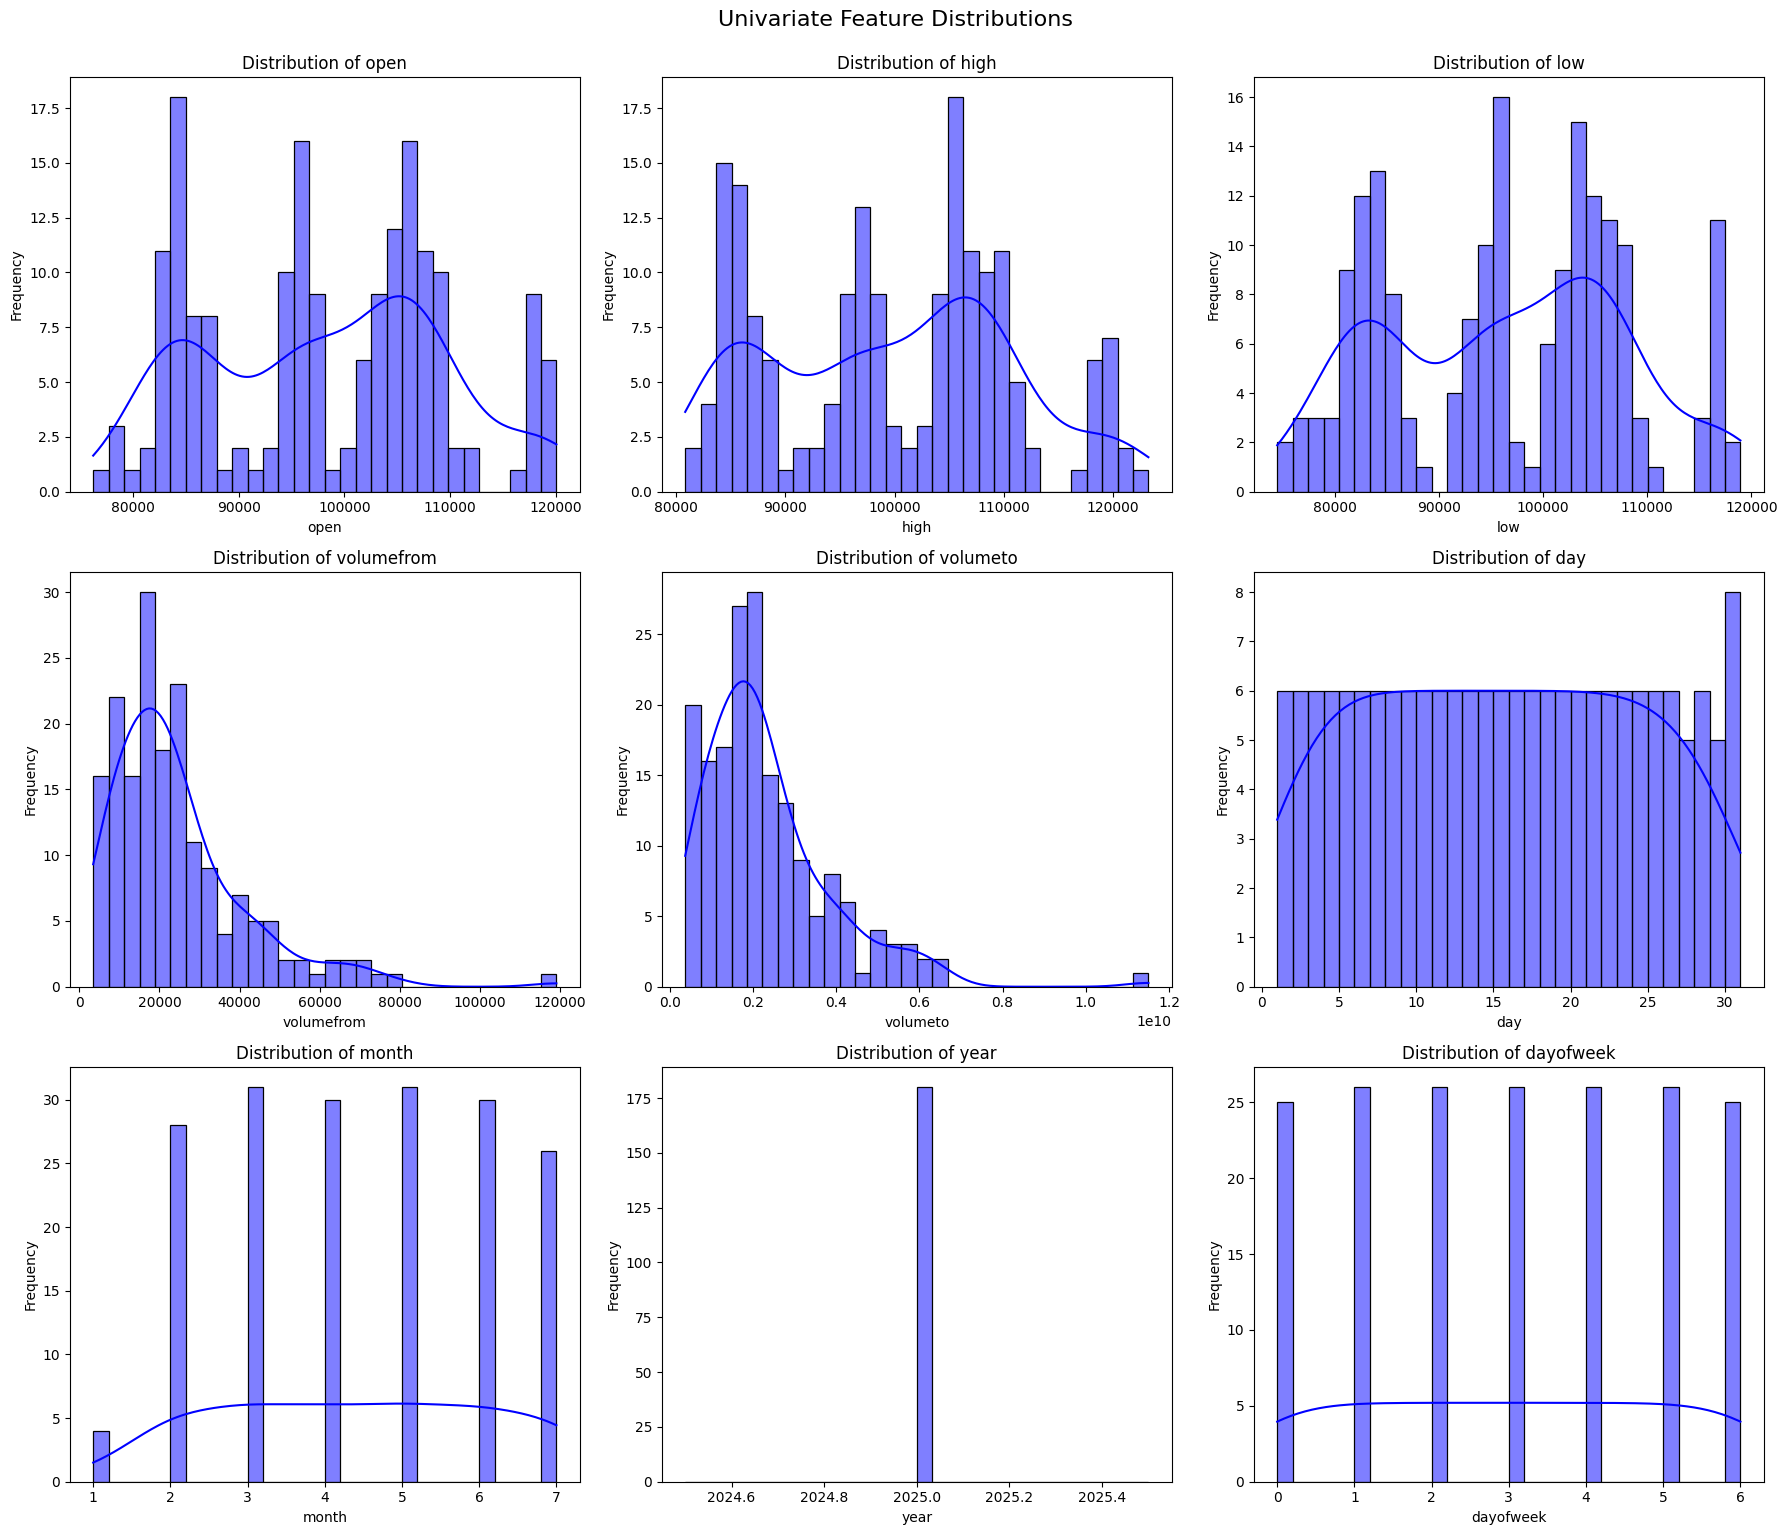

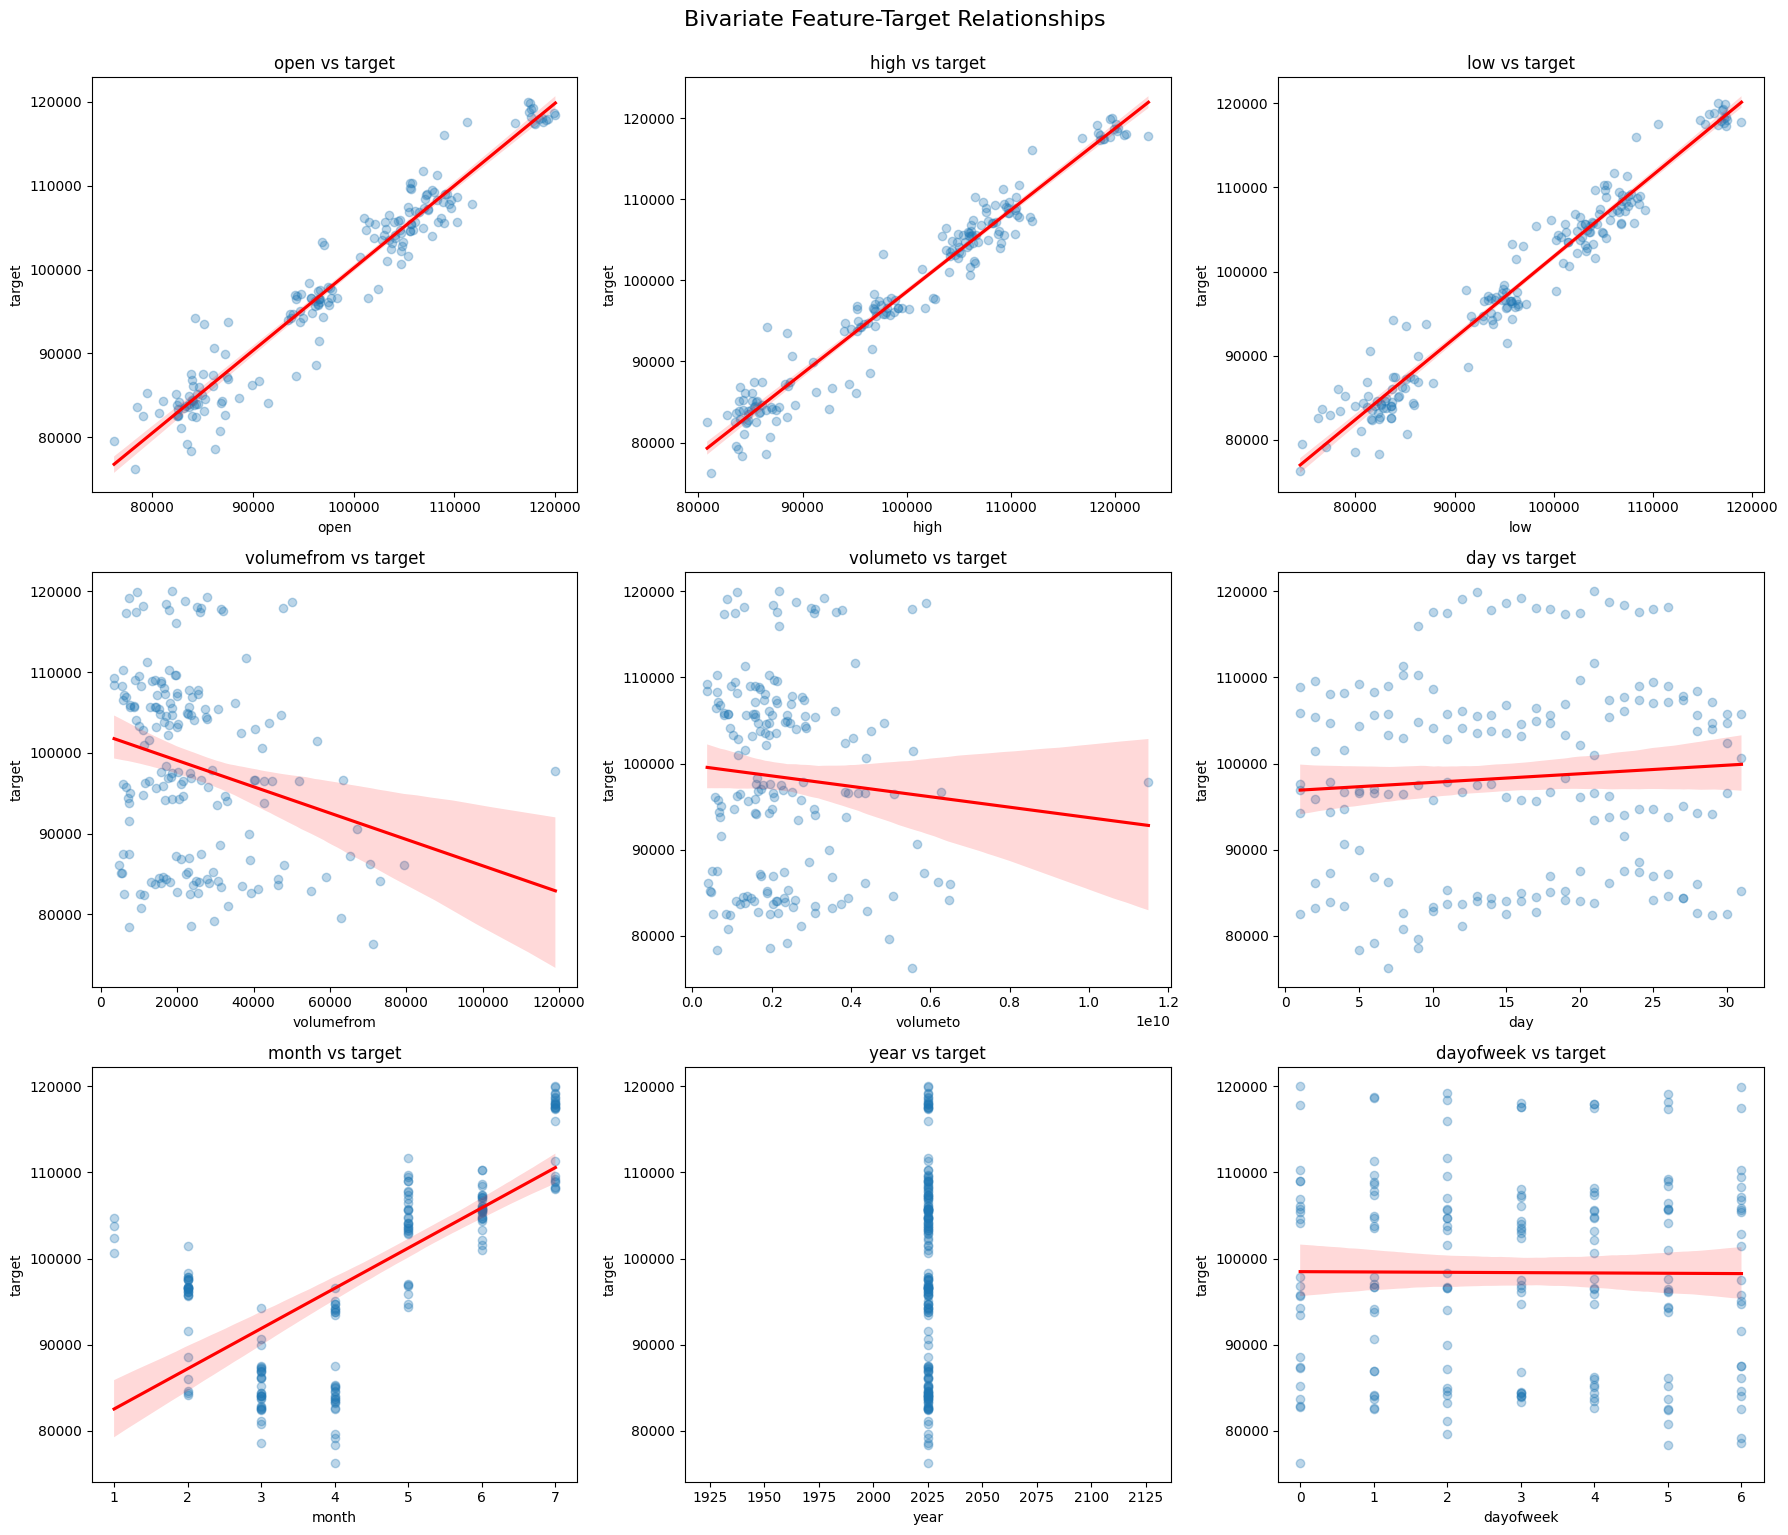

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. C

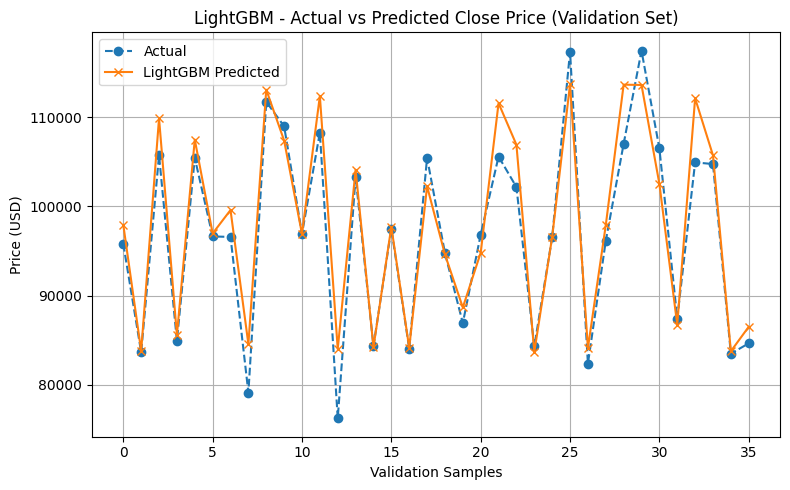

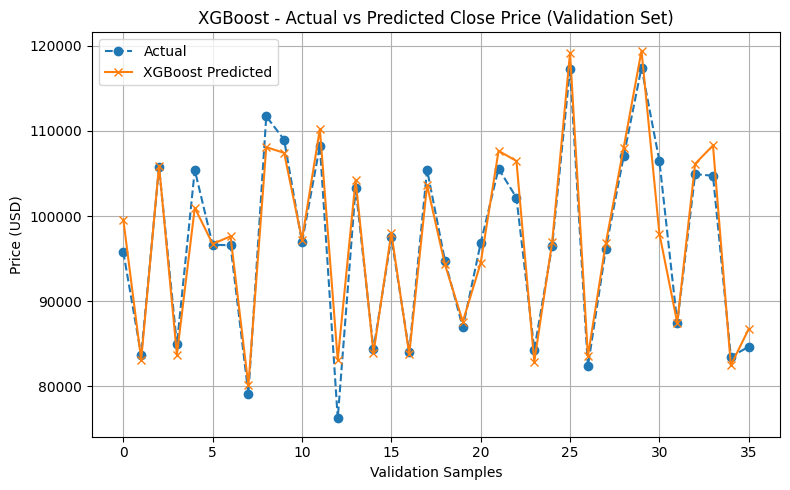

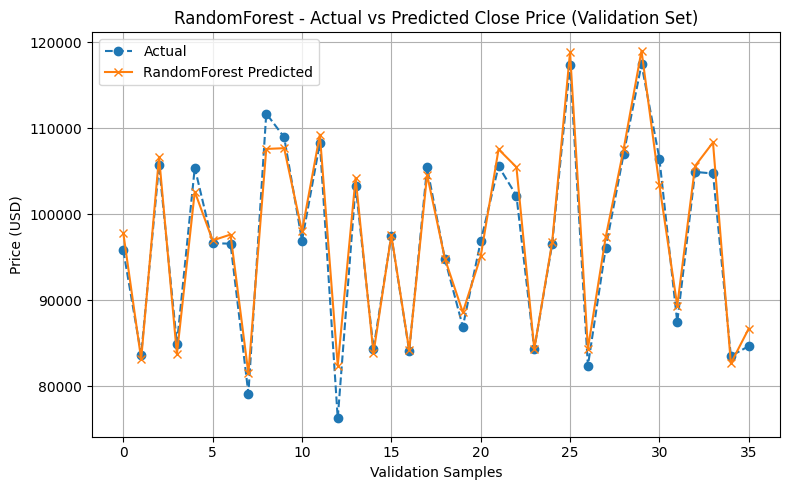

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


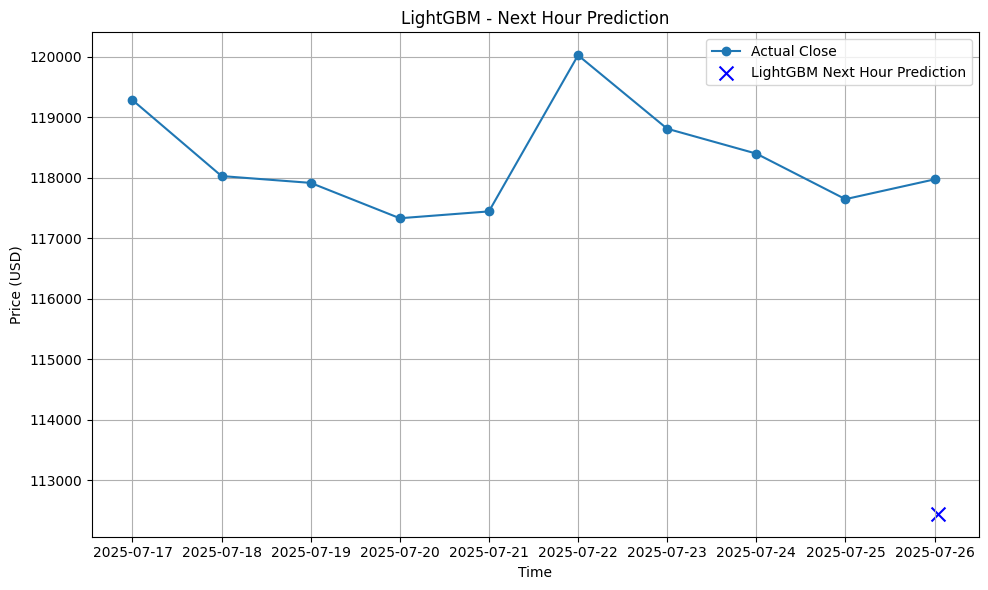

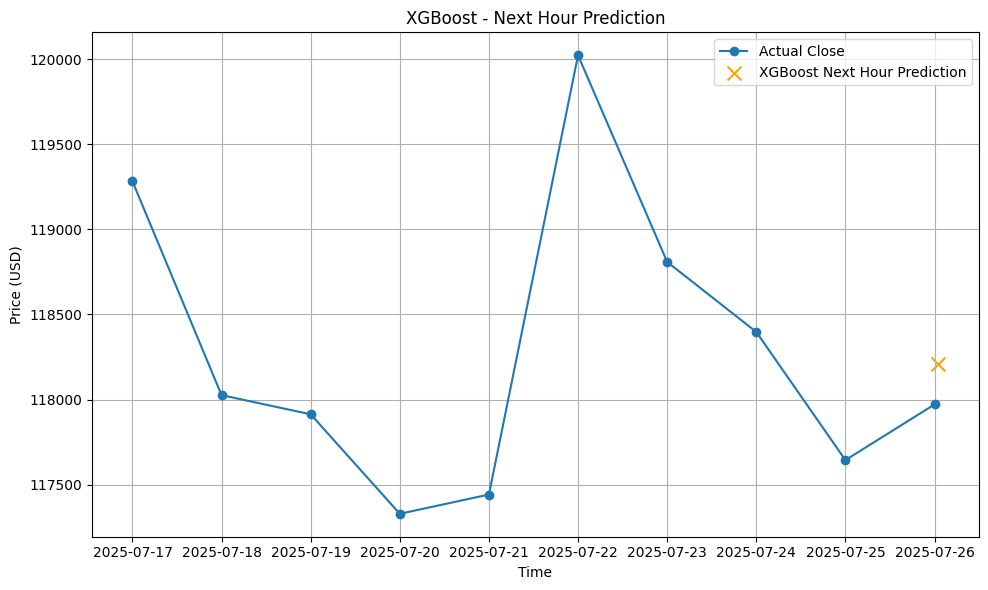

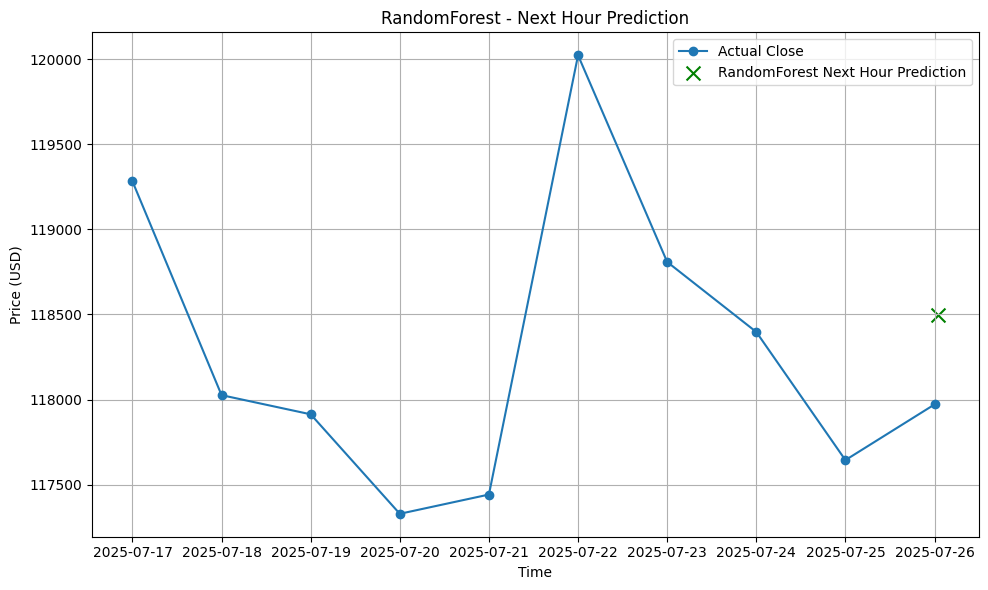

In [ ]:
# Example usage:
if __name__ == "__main__":

    features = ["open", "high", "low", "volumefrom", "volumeto", "day", "month", "year", "dayofweek"]

    #Skipping steps - Fetching data and Feature Engineering completed
    '''
    # Fetch data
    #df = fetch_crypto_data()

    # Feature Engineering
    #df = create_features(df)
    '''
    # Explore Data
    explore_crypto_data(df)

    # Plot Univariate Distribution
    plot_univariate_distributions(df, features)

    # Plot Bi-variate Distribution
    plot_bivariate_relationships(df,features = features)

    # Train models
    models, X_val, y_val = train_models(df)

    # Evaluate models
    evaluate_model(models, X_val, y_val)

    # Plot Actual vs Predicted for each model
    plot_comparison_individual(y_val, models, X_val)

    # Plot next hour prediction for each model
    plot_next_hour_prediction(models, df)

### ✅ Conclusion & Future Scope
This project successfully built a real-time crypto classifier that can predict short-term price movement using machine learning. Future extensions could include:
- Sentiment analysis from Twitter/Reddit
- LSTM-based sequence models
- Deployment on Streamlit or Flask

**Industry Alignment:** Binary prediction aligns with trading bots and risk control strategies in crypto hedge funds.